In [1]:
import pyanitools as pyt
#import pyaniasetools as aat
import pyNeuroChem as pyc
import hdnntools as hdt
import numpy as np

from ase_interface import ANIENS
from ase_interface import ensemblemolecule
from ase.atoms import Atoms

import matplotlib.pyplot as plt

#import aniensemblestats as ens

/scratch/Anaconda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


van Der Waals correction will be unavailable. Please install ased3


In [2]:
#h5files = '/home/jujuman/Research/DataReductionMethods/modelCNOSFCl/initial/cv1/testset/testset1.h5'
#h5files = '/home/jujuman/Seagate2TB/Research/ANI-DATASET/h5data/ani_data_c10test.h5'
#h5files = '/home/jujuman/Research/extensibility_test_sets/gdb-10/gdb11_10_test500.h5'
h5files = '/nh/nest/u/jsmith/scratch/Research/tin_research/model-70/testset/testset'

#wkdir = '/nh/nest/u/jsmith/scratch/Research/levi_test/ANI-2x_v62518'
wkdir = '/nh/nest/u/jsmith/scratch/Research/tin_research/model-70/'

cns = wkdir + '/train0/rSn-7.0R_32-6.0A_a8-8.params'
sae = wkdir + '/train0/sae_linfit.dat'
nnf = wkdir + '/train'
Nn = 1

In [3]:
#anicv = aat.anicrossvalidationconformer(cns, sae, nnf, Nn, [0])
#nc = pyc.molecule(cns,sae,nnf+str(0)+'/networks/', 0)



In [4]:
#hfile = '/nh/nest/u/jsmith/Research/gutzwiller_research/new_converged_data/20180723-MD/N100/U10.0-N10-ANI.h5'
#dpack = pyt.datapacker(hfile)

In [86]:
Eani_t = []
Edft_t = []
dEani_t = []
dEdft_t = []
Fani_t = []
Fdft_t = []
Estd = []
Volm = []

for j in range(Nn):
    # Set NC
    
    adl = pyt.anidataloader(h5files+str(2)+'.h5')
    #adl = pyt.anidataloader('/home/jujuman/Scratch/Research/tin_research/data-11.h5')
    
    for i,data in enumerate(adl):
        X = data['coordinates']
        S = data['species']
        
        #Fdft = data['forces']
        Edft = hdt.hatokcal*data['energies']
        Fdft = hdt.hatokcal*data['forces']
        C = data['cell']
        
        #if 'N' in S:
        Eani = []
        Fani = []
        Edftl = []
        Fdftl = []
        for x,c,e,f in zip(X,C,Edft,Fdft):

            if c[0,0] > 10.5 and c[1,1] > 8.0 and c[2,2] > 10.5:
                print(c)
                Volm.append(c[0,0]*c[1,1]*c[2,2])
                cell = np.array(c,dtype=np.float32)
                celi = (np.linalg.inv(cell)).astype(np.float32)

                aens = ensemblemolecule(cns, sae, nnf, 1, 0, net_start_id=j)
                aens.set_pbc(True,True,True)
                aens.set_cell((cell).astype(np.float32), celi)

                aens.set_molecule(x.astype(np.float32), S)
                energy, force, stddev, Fstddev = aens.compute_mean_props()
                Estd.append(stddev)
                Eani.append(energy)
                Fani.append(force.reshape(1,-1,3))
                
                Edftl.append(e)
                Fdftl.append(f)
        
        if len(Eani) > 0:
            Eani = hdt.hatokcal*np.array(Eani)
            Fani = hdt.hatokcal*np.stack(Fani)

            Edft = np.array(Edftl)
            Fdft = np.stack(Fdftl)
            
            dF = np.vstack(Fani)-Fdft
            dFstd =np.std(dF)

            fidx = np.where(np.abs(dF) > 10.0*dFstd)[0]
            eidx = np.where(np.abs(Eani-Edft) > 50.0)[0]
            if eidx.size>0 or fidx.size>0:
                print(data['path'])
                print('  -Force:',fidx)
                print('  -Energy:',eidx)
                print(np.abs(Eani-Edft))

            #print(Fani.shape)
            #Eani, Fani, Sig = anicv.compute_energyandforce_conformations(X=np.array(X,dtype=np.float32),S=S)
            #print(Fdft)
            #Eani = np.asarray(np.mean(Eani,axis=1))
            #print(Eani.shape,Edft.shape)
            #idx = np.where((Edft - Edft.min() < 300.0))
            #print(np.abs(Edft-Eani), len(S))

            #mina = Eani.min()
            #mind = Edft.min()

            Esae1 = hdt.hatokcal*hdt.compute_sae(sae,S)
            #Esae2 = hdt.hatokcal*hdt.compute_sae('/nh/nest/u/jsmith/scratch/Research/levi_test/train/sae_linfit.dat',S)

            Eani = (Eani-Esae1)/len(S)
            Edft = (Edft-Esae1)/len(S)

            Eani_t.append(Eani)
            Edft_t.append(Edft)
            #print(Eani_t[-1])

            Fani_t.append(Fani.flatten())
            Fdft_t.append(Fdft.flatten())

            #dEani_t.append(hdt.calculatedmat(Eani))
            #dEdft_t.append(hdt.calculatedmat(Edft))
            #print(np.abs(-Fani[0]-hdt.hatokcal*Fdft))


Eani_t = np.concatenate(Eani_t)
Edft_t = np.concatenate(Edft_t)
Fani_t = np.concatenate(Fani_t)
Fdft_t = np.concatenate(Fdft_t)
#dEani_t = np.concatenate(dEani_t)
#dEdft_t = np.concatenate(dEdft_t)

new_data = dict()

new_data["species"] = S
new_data["coordinates"] = X
new_data["energies"] = Eani_t
new_data["forces"] = Fani_t

#dpack.store_data('/kt015/ANI',**new_data)
#dpack.cleanup()

[[13.25599   0.        0.      ]
 [ 0.        8.046134  0.      ]
 [ 0.        0.       10.807476]]
[[10.899353  0.        0.      ]
 [ 0.       15.101936  0.      ]
 [ 0.        0.       11.781569]]
[[10.984074  0.        0.      ]
 [ 0.       11.0385    0.      ]
 [ 0.        0.       11.962689]]
[[10.502312  0.        0.      ]
 [ 0.        8.428147  0.      ]
 [ 0.        0.       10.724508]]
[[13.813583  0.        0.      ]
 [ 0.        9.080566  0.      ]
 [ 0.        0.       11.485621]]
[[12.091641   0.         0.       ]
 [ 0.         9.675453   0.       ]
 [ 0.         0.        12.8132105]]
[[12.707657  0.        0.      ]
 [ 0.       13.150607  0.      ]
 [ 0.        0.       12.608092]]

/scratch/Gits/NeuroChem/build/lib/ase_interface.py:530: RuntimeWarning: invalid value encountered in true_divide
  v2 = np.sum(np.sum(np.power(dF, 2), axis=0) / (self.Nn * (self.Nn - 1)))



[[13.739287  0.        0.      ]
 [ 0.       12.734533  0.      ]
 [ 0.        0.       10.841947]]
[[11.657769  0.        0.      ]
 [ 0.       13.937341  0.      ]
 [ 0.        0.       14.534056]]
[[11.701479  0.        0.      ]
 [ 0.       13.803041  0.      ]
 [ 0.        0.       10.556455]]
[[15.823769  0.        0.      ]
 [ 0.       12.639678  0.      ]
 [ 0.        0.       13.018879]]
[[14.170778   0.         0.       ]
 [ 0.         9.8914585  0.       ]
 [ 0.         0.        15.505623 ]]
[[13.455331  0.        0.      ]
 [ 0.       10.17149   0.      ]
 [ 0.        0.       13.577115]]
[[13.813583  0.        0.      ]
 [ 0.        9.080566  0.      ]
 [ 0.        0.       11.485621]]
[[14.900724  0.        0.      ]
 [ 0.        9.7073    0.      ]
 [ 0.        0.       11.87102 ]]
[[10.553324  0.        0.      ]
 [ 0.       13.862878  0.      ]
 [ 0.        0.       11.76588 ]]
[[12.889641  0.        0.      ]
 [ 0.       11.440522  0.      ]
 [ 0.        0.       11

In [87]:
#print(,Fani_t)
#Eani_t = np.concatenate(Eani_t)
#Edft_t = np.concatenate(Edft_t)
#print(Eani_t.shape, Edft_t.shape)

print('ERMS:',hdt.calculaterootmeansqrerror(Eani_t,Edft_t))
print('EMAE:',hdt.calculatemeanabserror(Eani_t,Edft_t))
print('FRMS:',hdt.calculaterootmeansqrerror(Fani_t,Fdft_t))
print('FMAE:',hdt.calculatemeanabserror(Fani_t,Fdft_t))
#print(hdt.calculaterootmeansqrerror(dEani_t,dEdft_t))
#print(hdt.calculatemeanabserror(dEani_t,dEdft_t))
#print(Eani_t.size)

ERMS: 0.19557589428554284
EMAE: 0.14198651658750516
FRMS: 8.659454
FMAE: 3.3801215


In [88]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.backends.backend_pdf import PdfPages

In [89]:
# ----------------------------------
# Plot force histogram
# ----------------------------------
def plot_corr_dist(Xa, Xp, inset=True, xlabel='$F_{dft}$' + r' $(kcal \times mol^{-1} \times \AA^{-1})$', ylabel='$F_{dft}$' + r' $(kcal \times mol^{-1} \times \AA^{-1})$', figsize=[13,10], cmap=mpl.cm.viridis):
    Fmx = Xa.max()
    Fmn = Xa.min()

    label_size = 14
    mpl.rcParams['xtick.labelsize'] = label_size
    mpl.rcParams['ytick.labelsize'] = label_size

    fig, ax = plt.subplots(figsize=figsize)

    # Plot ground truth line
    ax.plot([Fmn, Fmx], [Fmn, Fmx], '--', c='r', linewidth=3)

    # Set labels
    ax.set_xlabel(xlabel, fontsize=22)
    ax.set_ylabel(ylabel, fontsize=22)

    #cmap = mpl.cm.viridis
    #cmap = mpl.cm.brg

    # Plot 2d Histogram
    bins = ax.hist2d(Xa, Xp, bins=200, norm=LogNorm(), range= [[Xa.min(), Xa.max()], [Xp.min(), Xp.max()]], cmap=cmap)

    # Build color bar
    #cbaxes = fig.add_axes([0.91, 0.1, 0.03, 0.8])
    cb1 = fig.colorbar(bins[-1], cmap=cmap)
    cb1.set_label('Count', fontsize=16)

    # Annotate with errors
    PMAE = hdt.calculatemeanabserror(Xa, Xp)
    PRMS = hdt.calculaterootmeansqrerror(Xa, Xp)
    ax.text(0.75*((Fmx-Fmn))+Fmn, 0.43*((Fmx-Fmn))+Fmn, 'MAE='+"{:.3f}".format(PMAE)+'\nRMSE='+"{:.3f}".format(PRMS), fontsize=20,
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5})

    if inset:
        axins = zoomed_inset_axes(ax, 2.2, loc=2) # zoom = 6

        sz = 6
        axins.hist2d(Xa, Xp,bins=50, range=[[Fmn/sz, Fmx/sz], [Fmn/sz, Fmx/sz]], norm=LogNorm(), cmap=cmap)
        axins.plot([Xa.min(), Xa.max()], [Xa.min(), Xa.max()], '--', c='r', linewidth=3)

        # sub region of the original image
        x1, x2, y1, y2 = Fmn/sz, Fmx/sz, Fmn/sz, Fmx/sz
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.yaxis.tick_right()

        plt.xticks(visible=True)
        plt.yticks(visible=True)

        mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

        Ferr = Xa - Xp
        std = np.std(Ferr)
        men = np.mean(Ferr)
        axh = plt.axes([.49, .16, .235, .235])
        axh.hist(Ferr, bins=75, range=[men-4*std, men+4*std], normed=True)
        axh.set_title('Difference distribution')

    #plt.draw()
    plt.show()

In [90]:
from scipy import stats
Fgradient, Fintercept, r_value, p_value, std_err = stats.linregress(Fani_t,Fdft_t)
Egradient, Eintercept, r_value, p_value, std_err = stats.linregress(Eani_t,Edft_t)

In [91]:
print(Egradient,Eintercept,Fgradient)

1/.97

0.9972423156871449 -0.016424438975986 1.0036956277634


1.0309278350515465

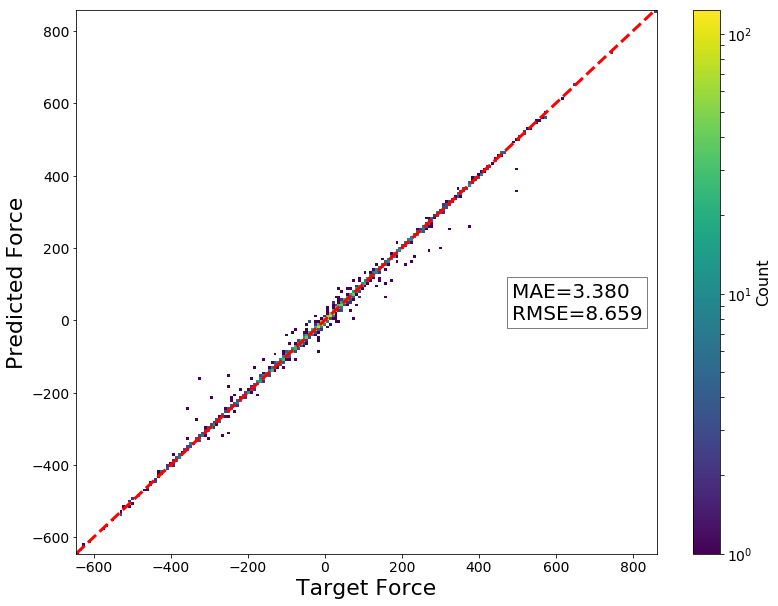

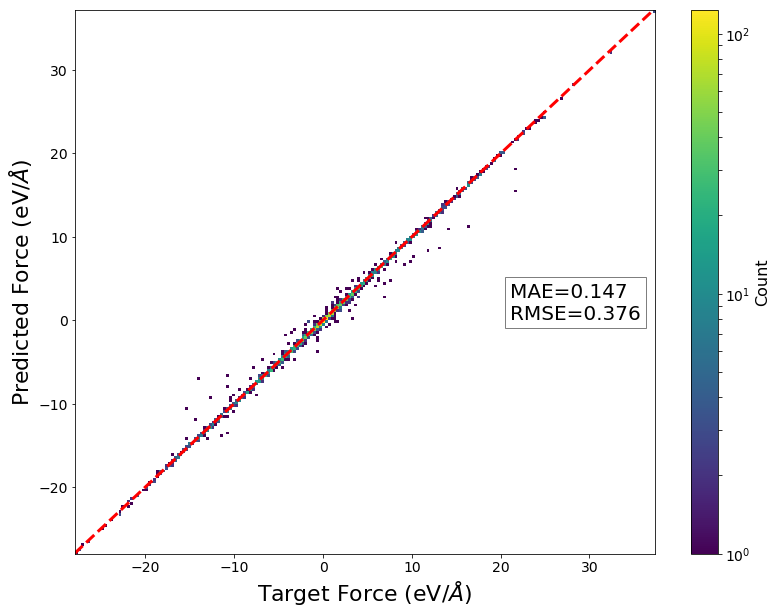

In [92]:
plot_corr_dist(Fdft_t,Fani_t,xlabel='Target Force',ylabel='Predicted Force',inset=False)
plot_corr_dist(Fdft_t/hdt.evtokcal,Fani_t/hdt.evtokcal,xlabel=r'Target Force (eV/$\AA$)',ylabel=r'Predicted Force (eV/$\AA$)',inset=False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22]),)


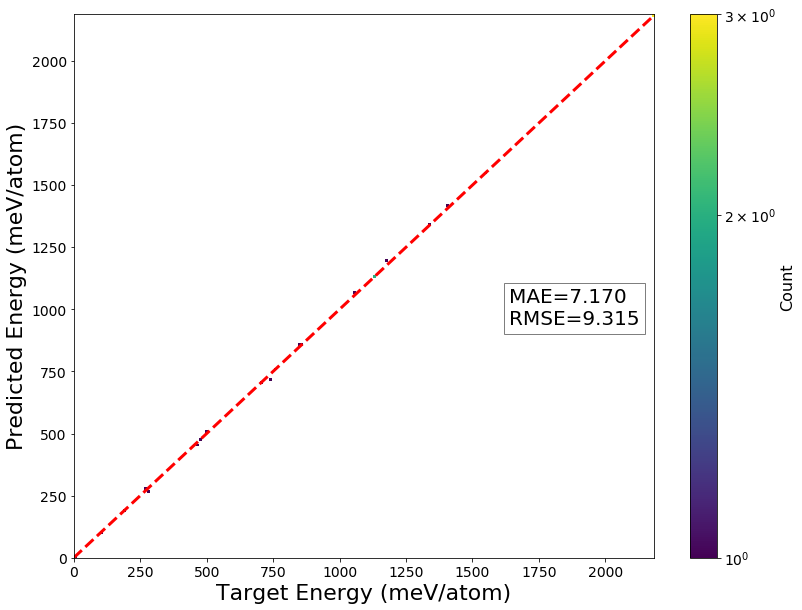

In [93]:
Edft_t = Edft_t - Edft_t.min()
Eani_t = Eani_t - Eani_t.min()

idx = np.where(1000.0*Edft_t/hdt.evtokcal < 90000000.0)
print(idx)
plot_corr_dist(1000.0*Edft_t[idx]/hdt.evtokcal,1000.0*Eani_t[idx]/hdt.evtokcal,xlabel='Target Energy (meV/atom)',ylabel='Predicted Energy (meV/atom)', inset=False)

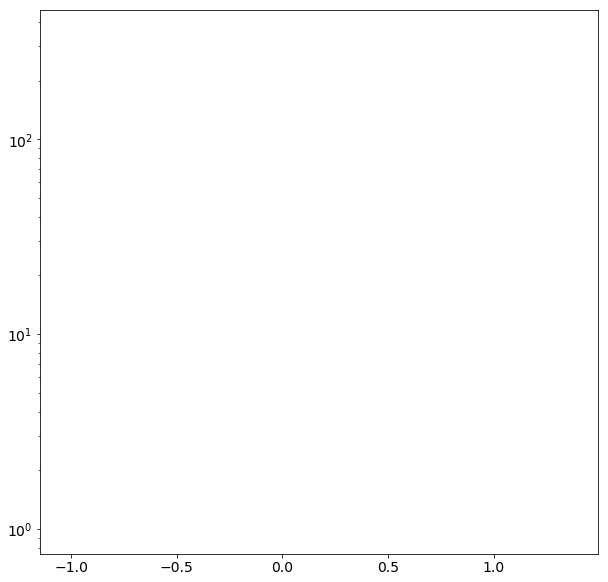

In [94]:
fig = plt.figure(figsize=[10,10])
idx = np.where(np.abs(Fdft_t)/hdt.hatokcal<3)
plt.hist(Fdft_t[idx]/hdt.hatokcal,bins=100)
plt.yscale("log")
plt.show()

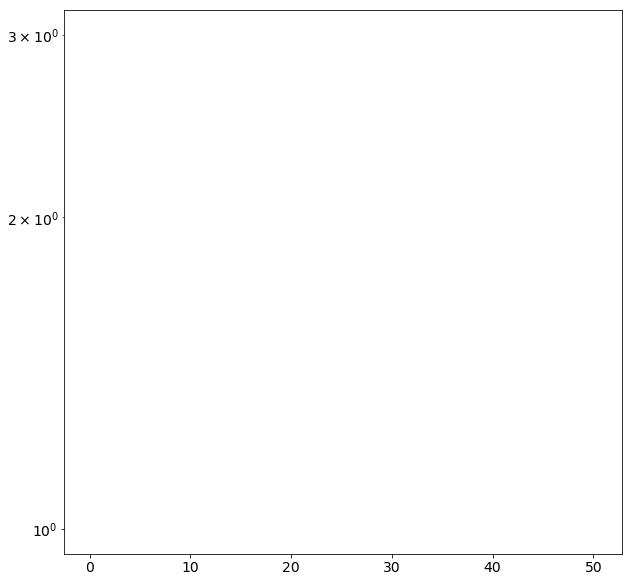

In [95]:
fig = plt.figure(figsize=[10,10])
plt.hist(Edft_t,bins=100)
plt.yscale("log")
plt.show()

In [85]:
fig = plt.figure(figsize=[10,10])
plt.hist(np.linalg.norm(Fdft_t,axis=1),bins=100)
plt.yscale("log")
plt.xlabel("Gutz force magnitude")
plt.ylabel("Count")
plt.show()

AxisError: axis 1 is out of bounds for array of dimension 1